In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d datasnaek/mbti-type
!unzip mbti-type.zip

In [ ]:
import re
import string
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm.auto import tqdm

nltk.download('punkt')


In [62]:
data = pd.read_csv("mbti_1.csv")

mbti_map = {
    "ISTJ": 0,
    "ISFJ": 1,
    "INFJ": 2,
    "INTJ": 3,
    "ISTP": 4,
    "ISFP": 5,
    "INFP": 6,
    "INTP": 7,
    "ESTP": 8,
    "ESFP": 9,
    "ENFP": 10,
    "ENTP": 11,
    "ESTJ": 12,
    "ESFJ": 13,
    "ENFJ": 14,
    "ENTJ": 15,
}


rows_amount = len(data)

visualization

<Figure size 640x480 with 0 Axes>

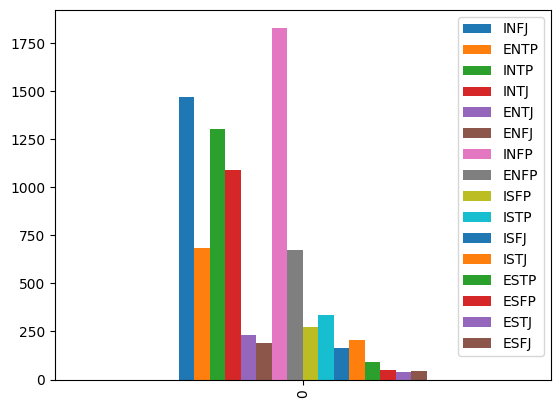

In [63]:
counts = collections.defaultdict(int)
for row in data["type"]:
    counts[row] += 1

counts = dict(counts)
for key, value in counts.items():
    counts[key] = [value]


plotdata = pd.DataFrame(counts)
plt.figure();
plotdata.plot.bar();


preprocessing

In [64]:
PATH = "mbti_1.csv"


def reg_handling(content: str) -> str:
    "preprocessing posts"

    content = re.sub(r"http\S*", " ", content.lower().lstrip("'"))
    content = re.sub(r'\|{3,}', ' N ', content)
    content = content.translate(str.maketrans(' ', ' ', string.punctuation))
    content = re.sub(r'[^A-z]', ' ', content)

    return content


def write_post(position: int, mbti_type: str, content: str) -> None:
    match position:
        case _ if position < int(0.75*rows_amount):
            with open("train.csv", "a") as train:
                train.write(f"{mbti_type}\t{content}\n")
        case _:
            with open("test.csv", "a") as test:
                test.write(f"{mbti_type}\t{content}\n")


for file_ in ["train.csv", "test.csv"]:
    with open(file_, "w") as f:
        f.write("type\tcontent\n")


with open(PATH) as f:
    csv_data = csv.reader(f)
    posts = next(csv_data) # skipping row "posts"
    for i, (mbti_type, content) in enumerate(csv_data):
        preprocessed = reg_handling(content)
        segments = preprocessed.split(" N ")
        chunks = [segments[i:i+len(segments)//4] for i in range(0, len(segments), len(segments)//4 + 1)]
        new_strings = [' '.join(chunk) for chunk in chunks]
        [write_post(i, mbti_type, new_string) for new_string in new_strings]

vocabulary

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train = pd.read_csv("train.csv", sep="\t")
test = pd.read_csv("test.csv", sep="\t")

dataset = {"train": train, "test" : test}

words = Counter()

for example in dataset['train']['content']:
    for word in word_tokenize(str(example)):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 20

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)


word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [167]:
def evaluate_accurcy(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy


def top_5_accurcy(model, eval_dataloader):
    predictions, target, means = [], [], []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(torch.topk(logits, 5, dim=1))
            target.append(batch['label'])

    for (val, ind), real in zip(predictions, target):
        result = [truth in top5 for top5, truth in zip(ind, real)]
        means.append(result.count(True)/len(result))

    return means


class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> list[int]:
        processed_text = self.data['content'][idx]
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(str(processed_text))
        ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data['type'][idx]
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: list[list[int]], pad_id=word2ind['<pad>'], max_len=1024) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([mbti_map[ x['label'] ] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch




In [67]:
train_dataset = WordDataset(dataset['train'])
test_dataset = WordDataset(dataset['test'])

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size)

eval_dataloader = DataLoader(
    test_dataset, shuffle=False,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size)


In [105]:
class Model(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes, bidirectional, num_layers, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=bidirectional, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)


    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = output.max(dim=1)[0]
        output = self.dropout(self.non_linear(self.linear(output)))
        prediction = self.projection(self.non_linear(output))

        return prediction

In [119]:
num_epochs = 2
losses, acc = [100], [0]

model = Model(hidden_dim=315, vocab_size=len(vocab), num_classes=16,
              bidirectional=False, num_layers=2, dropout_rate=0.2).to(device)

#model.load_state_dict(torch.load("common_1.pt"))

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(num_epochs):
    losses_per_epoch = []
    model.train()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch+1}: ')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()
        losses_per_epoch.append(loss.item())

    model.eval()
    epoch_acc = evaluate_accurcy(model, eval_dataloader)

    torch.save(model, f"model_{epoch+1}.pt")

    losses.append(sum(losses_per_epoch) / len(losses_per_epoch))
    acc.append(epoch_acc)

    print(f"loss: {losses[-1]} accuracy: {acc[-1]}")



Training epoch 1:   0%|          | 0/204 [00:00<?, ?it/s]

loss: 2.106058806180954 accuracy: 0.43127307295799255


Training epoch 2:   0%|          | 0/204 [00:00<?, ?it/s]

loss: 1.7455903712440939 accuracy: 0.4629843235015869


results: accurcy / top-5 accurcy

In [170]:
model.eval()
predictions, target, means = [], [], []
with torch.no_grad():
    for batch in eval_dataloader:
        logits = model(batch['input_ids'])
        predictions.append(torch.topk(logits, 5, dim=1))
        target.append(batch['label'])


In [ ]:
for (val, ind), real in zip(predictions, target):
    result = [truth in top5 for top5, truth in zip(ind, real)]
    print(result)
    means.append(result.count(True)/len(result))

In [173]:
sum(means)/len(means)

0.8149892769607844

In [169]:
print(top_5_accurcy)

<function top_5_accurcy at 0x7e26241c9ea0>


one sample prediction

In [181]:
data = dataset["test"].head(1) # for test
data["content"][0] = reg_handling("hello my name is john I think in strictly way. I am a human by the way").replace("N", " ")

loader = DataLoader(
    test, shuffle=True,
    collate_fn=collate_fn_with_padding,
    batch_size=1)

model.eval()
batch = next(iter(loader))
logits = model(batch['input_ids']).argmax(dim=1)
res = int(logits.numpy())

key_list = list(mbti_map.keys())
val_list = list(mbti_map.values())
position = val_list.index(res)
print(key_list[position])

INTP


<ipython-input-181-42e6d711e7ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["content"][0] = reg_handling("hello my name is john I think in strictly way. I am a human by the way").replace("N", " ")
